# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/466fd641958f8333f518c90c5f21321c7e5979287577671d966a2cd5.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Portland, Oregon, United States**, and the stations the data comes from are shown on the map below.

In [42]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
%matplotlib inline
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'466fd641958f8333f518c90c5f21321c7e5979287577671d966a2cd5')

<IPython.core.display.HTML object>

# Load the Data

In [56]:
pandas = pd
pyplot = plt
hash_id = ("466fd641958f8333f518c90c5f21321c7e5979287577671d966a2cd5")
file_name = 'data/C2A2_data/{0}.csv'.format(hash_id)
data = pandas.read_csv(file_name)

## Add A Day Of Year Column

Since we have to compare days of the year I'm adding a column that maps the date-strings to the (integer) day of the year.

In [44]:
data["TimeStamp"] = pandas.to_datetime(data.Date)
data["DayOfYear"] = data.TimeStamp.apply(lambda stamp: stamp.dayofyear)

## Remove Leap-Days

The date-string is formatted ("YYYY-MM-DD") so we can find all the leap days by searching for dates that end with "02-29"

In [46]:
leap_years = data[data.Date.str.endswith("02-29")].Date.unique()
leap_years = [year.split("-")[0] for year in leap_years]

Since I'm using the day of the year to match the data and leap years have all their day-numbers shifted ahead by 1 after February 28th, I'm going to save the day-number for February 29th so I can reset them later.

In [47]:
leap_day = data[data.Date.str.endswith("02-29")].DayOfYear.unique()[0]

Now filter out leap-days.

In [48]:
starting = len(data)
data = data[~data.Date.str.endswith('02-29')]
assert not any(data.Date.str.endswith("02-29"))
assert not "2012-02-29" in data.Date
assert not "2008-02-29" in data.Date
assert len(data) < starting

And move the day-numbers for March 1 through December 31 back one value since we removed a day.

In [49]:
for year in leap_years:
    data.DayOfYear[
        data.Date.str.startswith(year)] = data.DayOfYear[
            data.Date.str.startswith(year)].apply(
                lambda day: day-1 if day > leap_day else day)
assert 366 not in data.DayOfYear.unique()

# Getting the Highs and Lows

First I'm splitting the 2015 data from the non-2015 data.

In [50]:
fifteen = data[data.Date.str.startswith("2015")]
historical = data[~data.Date.str.startswith("2015")]
assert len(fifteen) + len(historical) == len(data)

Next I'm grouping the data by the *DayOfYear* variable so I can compare the temperatures within the same day for all the years.

First the 2005 through 2014 data.

In [51]:
h_groups = historical.groupby("DayOfYear")
maxes = h_groups.Data_Value.max()
mins = h_groups.Data_Value.min()

Now the 2015 data.

In [52]:
f_groups = fifteen.groupby("DayOfYear")
f_maxes = f_groups.Data_Value.max()
f_mins = f_groups.Data_Value.min()

Now I filter out the 2015 data that isn't outside of the 2005 through 2014 values.

In [53]:
f_maxes = f_maxes[f_maxes > maxes]
f_mins = f_mins[f_mins < mins]

# Prepare to Plot

Since the temperatures are in tenths of a degree I'm going to scale them to make it easier to understand their meaning when plotted.

In [54]:
maxes = maxes/10
mins = mins/10
f_maxes = f_maxes/10
f_mins = f_mins/10

## Plot the historical data.

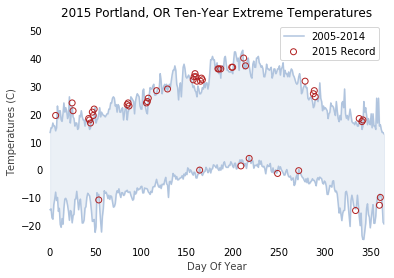

In [65]:
# First the maximum and minimum values.
pyplot.plot(maxes.index, maxes, color="lightsteelblue")
pyplot.plot(mins.index, mins, color="lightsteelblue", label="2005-2014")

# Now fill in the space between the maximum and minum line plots.
axe = pyplot.gca()
axe.fill_between(mins.index, maxes, mins,
                 where=mins<=maxes, interpolate=True,
                 color="lightsteelblue",
                 alpha=0.25)

# Plot the 2015 Records
# The scatter plot was showing up under the line plots and the *zorder* setting moves it up in front.
pyplot.scatter(f_maxes.index, f_maxes, facecolor="none", edgecolor="firebrick", zorder=3, label="2015 Record")
pyplot.scatter(f_mins.index, f_mins, facecolor="none", edgecolor="firebrick", zorder=3, label="Record Low")

# Add the labels and titles.
axe.set_xlabel("Day Of Year", alpha=0.75)
axe.set_ylabel("Temperatures (C)", alpha=0.75)
axe.set_title("2015 Portland, OR Ten-Year Extreme Temperatures")

# Clean up the tick-marks and border and add a legend.
axe.axis([0, 365, min(mins.min(), f_mins.min()), max(maxes.max(), f_maxes.max()) + 10])
pyplot.tick_params(axis="both", which="both", bottom="off", left="off")
handles, labels = axe.get_legend_handles_labels()
axe.legend(handles[1:3], labels[1:3])
for key in axe.spines:
    axe.spines[key].set_visible(False)
pyplot.savefig("max_min.png")